# Imports

In [1]:
from sklearn.datasets import load_wine
from networkx.drawing.nx_agraph import graphviz_layout
from tqdm.notebook import trange, tqdm
from sklearn.model_selection import train_test_split
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
import pydotplus
import networkx as nx
import pandas as pd
import numpy as np
import copy
import uuid

# Code

In [2]:
class Node:
  def __init__(self,
               name: str,
               value : float or int,
               cond_type : int = 0,
               depth : int = 0,
               leaf : bool = False):

    self.name = name
    self.value = value
    self.cond_type = cond_type

    if cond_type == 0: #Categorical
      self.symbol = '<='
    elif cond_type == 1: #Scalar
      self.symbol = '='

    self.depth = depth
    self.leaf = leaf

    self.left = None    #true
    self.right = None   #false

    self.identifier = uuid.uuid4()


  def decision(self,
               x: float or int):

    return x <= self.value if self.cond_type == 0 else  self.value == x


In [3]:
class Tree:

  def __init__(self,
               all_features: np.ndarray,
               targets: np.ndarray,
               max_depth: int = 5):

    self.all_features = all_features
    self.max_depth = max_depth

    self.chosen_features = np.random.choice(self.all_features, max_depth,
                                            replace=True)

    self.features = {feature : self.all_features.index(feature) for feature in self.chosen_features}

    self.targets = targets
    self.root = None
    self.nodes = None

    self.score = 0

  def __deepcopy__(self, obj):
        new = type(self)(copy.deepcopy(self.all_features, obj),
                         copy.deepcopy(self.chosen_features, obj),
                         copy.deepcopy(self.targets, obj),
                         copy.deepcopy(self.max_depth, obj)
                         )
        new.features = copy.deepcopy(self.features, obj)
        new.root = copy.deepcopy(self.root, obj)
        new.nodes = copy.deepcopy(self.nodes, obj)

        return new

  def get_params(self):
    return self.chosen_features, self.max_depth, self.score

  def insert_node(self,
                  node: Node,
                  key_name: str,
                  key_value: float or int = 0,
                  current_depth: int = 0):

    if node is None:
      return Node(key_name, key_value, depth=current_depth, cond_type=0)

    else:
      current_depth += 1
      direction = np.random.rand()
      if direction <= 0.5:
        node.left = self.insert_node(node.left, key_name, key_value, current_depth)
      else:
        node.right = self.insert_node(node.right, key_name, key_value, current_depth)

    return node


  def set_outputs(self,
                  node : Node,
                  outputs_classes: np.ndarray,
                  before_label: str = '',
                  current_depth : int = 0,
                  direction: str = 'right'):

    current_depth += 1

    if node is None:
      label = np.random.choice(outputs_classes)
      value = float(label.split('_')[1])
      return Node(label, int(value), depth=current_depth, leaf=True)

    else:
      if node.right and node.left is None:
        left_output_classes = np.delete(outputs_classes, np.where(outputs_classes == node.right.name))
      else:
        left_output_classes = outputs_classes
      node.left = self.set_outputs(node.left, left_output_classes, node.name, current_depth, direction='left')

      if node.left and node.right is None:
        right_output_classes = np.delete(outputs_classes, np.where(outputs_classes == node.left.name))
      else:
        right_output_classes = outputs_classes
      node.right = self.set_outputs(node.right, right_output_classes, node.name, current_depth)

    return node


  def to_nodes(self,
               node: Node,
               nodes: np.ndarray,):
    if node and not node.leaf:
      nodes.append(node)
      self.to_nodes(node.left, nodes)
      self.to_nodes(node.right, nodes)


  def get_nodes(self):
    nodes = []
    self.to_nodes(self.root, nodes)
    return nodes


  def create(self):
    for feature in self.chosen_features:
      self.root = self.insert_node(self.root, feature, np.random.normal())

    self.root = self.set_outputs(self.root, self.targets)
    self.nodes = self.get_nodes()


  def make_predict(self,
                   cell: np.ndarray):

    node = self.root
    while node:
      if node.leaf:
        return node.value

      elif node.decision(cell[self.features[node.name]]):
        node = node.left

      else:
        node = node.right


  def predict(self,
              data: np.ndarray):
    results = []
    for cell in data:
      results.append(self.make_predict(cell))

    return results


  def to_graph(self,
               graph,
               node: Node):

    if node.left is not None:
        graph.add_edge(node.identifier, node.left.identifier)
        self.to_graph(graph, node.left)

    if node.right is not None:
        graph.add_edge(node.identifier, node.right.identifier)
        self.to_graph(graph, node.right)


  def get_labels(self,
                 node: Node,
                 labels: dict):

    if node:
      labels[node.identifier] = f'{node.name} {node.symbol} {node.value:.4}' if not node.leaf else f'{node.name}'
      self.get_labels(node.left, labels)
      self.get_labels(node.right, labels)


  def show(self):
    graph = nx.Graph()
    self.to_graph(graph, self.root)

    labels = {}
    self.get_labels(self.root, labels)
    pos = graphviz_layout(graph, prog="dot")

    plt.figure(figsize=(13, 5))
    nx.draw(graph, pos,
            labels=labels,
            with_labels=True,
            node_size=500,
            font_size=10,
            font_color="white",
            font_weight="bold",
            linewidths=0.5,
            edge_color="gray",
            style="dashed",
            bbox=dict(facecolor="black", edgecolor='black', boxstyle='round, pad=1.0'))

    plt.show()

In [112]:
class Genetic:

  def __init__(self,
               pop_size: int,
               epochs: int,
               model: Tree,
               mutation_rate: float = 5e-2,
               documentation = False):

    # Parameters AG
    self.epochs = epochs
    self.pop_size = pop_size
    self.model = model
    self.mutation_rate = mutation_rate
    self.save_rate = mutation_rate
    
    # Properties AG
    self.n_nodes = len(model.nodes)
    self.population = []
    self.ranks = []
    self.no_improvement = 0
    self.patience_genocide = 0
    
    self.elite_pop = []
    self.elite_size = int(pop_size / 5)
    self.elite_mutation = .075
    
    # Best individual
    self.best = None
    self.best_score = None
    self.elite_is_best = []
    self.population_is_best = []
    
    # Worst individual
    self.worst = None
    self.worst_score = None
    self.worst_idx = 0
        
    # Save data
    self.documentation = documentation
    self.initial_pop = []
    self.population_history = []
    self.best_history = []
    self.results = pd.DataFrame(columns = ['epoch', 'agent', 'mutation', 'best_score', 'score'])
    self.results_elite = pd.DataFrame(columns = ['epoch', 'agent', 'best_score', 'score', 'individuo'])
    # self.results_train = pd.DataFrame(columns = ['epoch', 'best_score', 'mutation_rate'])
      
      
  def start_pop(self):
    self.population = np.random.normal(size=(self.pop_size, self.n_nodes))
    self.initial_pop = self.population.copy()
    self.elite_pop = np.random.normal(size=(self.elite_size, self.n_nodes))
    
    self.best = self.population[0]
    self.best_score = 0
    self.best_idx = 0 # tirar se matar o melhor e so usar p/ cross
  
    self.worst = self.population[0]
    self.worst_score = 1
    self.worst_idx = 0
      
  def predation_rand(self, index = None):
    if index == None:
      self.population[self.worst_idx] = np.random.normal(size=(1, self.n_nodes))
    else:
      self.population[index] = np.random.normal(size=(1, self.n_nodes))

  def evaluation_function(self,
                          data: np.ndarray,
                          target: np.ndarray,
                          sample_size: int):

    return sum(self.model.predict(data) == target) / sample_size
  
  
  def set_best(self, agent, score, idx):
    self.best = agent.copy() # salva o melhor para cross over
    self.best_score = score
    # agent = np.random.normal(size=(1, self.n_nodes)) # inicializa com valores randomicos -> demais convergem para o melhor novamente
    self.mutation_rate = self.save_rate
    self.no_improvement = 0
    self.best_idx = idx
  
  def set_worst(self, agent, score, idx):
    self.worst = agent
    self.worst_score = score
    self.worst_idx = idx
      
  def evaluation(self,
                 data: np.ndarray,
                 target: np.ndarray,
                 epoch: int,
                 ranking = False):

    sample_size = len(target)
    self.ranks = []
    
    # Avaliacao elite
    for i, agent in enumerate(self.elite_pop):
      for node, value in zip(self.model.nodes, agent):
        node.value = value
          
      score = self.evaluation_function(data, target, sample_size)
      self.results_elite.loc[len(self.results_elite)] = [epoch, i ,self.best_score, score, agent]

      if (score > self.best_score):
        self.set_best(agent, score, i)
        self.elite_is_best.append(epoch)
    
    # Avaliacao populacao geral
    for i, agent in enumerate(self.population):
      for node, value in zip(self.model.nodes, agent):
        node.value = value

      score = self.evaluation_function(data, target, sample_size)
      self.results.loc[len(self.results)] = [epoch, i, self.mutation_rate ,self.best_score, score]
      
      if ranking: self.ranks.append(score)
      if (score > self.best_score):
        self.set_best(agent, score, i)
        self.population_is_best.append(epoch)
      if (score < self.worst_score): self.set_worst(agent, score, i)
        
    
  def cross_and_mutation(self, general_pop = True):
    population = self.population if general_pop else self.elite_pop
    
    for i, agent in enumerate(population):
      #mutation
      if general_pop:
        # elitismo
        cross_best = (agent + self.best) / 2
        idx = np.random.randint(0, self.n_nodes)
        mutation = np.random.normal() * self.mutation_rate
        cross_best[idx] += 2*mutation if np.random.rand() < 0.50 else -2*mutation # espaço de busca = 2 (valor eixo)
        population[i] = cross_best.copy()
      else:
        for _ in range(2): # colocar proporcional ao tamanho do cromossomo?
          # reprodução assexuada
          idx = np.random.randint(0, self.n_nodes)
          agent[idx] *= (1 + self.elite_mutation) if np.random.rand() < 0.50 else (1 - self.elite_mutation) # ajuste fino -> % no valor e não no espaço de busca
        population[i] = agent.copy()
      

  def set_elite(self):
    for i in range(self.elite_size):
      cross_best = self.best
      idx = np.random.randint(0, self.n_nodes)
      cross_best[idx] *= (1 + 3*self.elite_mutation) if np.random.rand() < 0.50 else (1 - 3*self.elite_mutation)
      self.elite_pop[i] = cross_best.copy()

  def train(self,
            data: np.ndarray,
            target: np.ndarray,
            bar_train: bool = False,
            desc : str = 'Train'):

    self.start_pop()
    self.population_history = [self.population.copy()]
    
    flag_pred = 0
    for i in range(self.epochs):
      # rankeamento -> predacao randomica
      pred_rand = (np.mean(self.calculate_diversity(self.population)) < 0.05)
      flag_pred += 1 if pred_rand else 0
      
      # A cada 20 epoch faz grupo "elite" -> buscar ajuste fino
      if ((i % 20 == 0) and (i)):
        self.set_elite()
      
      self.evaluation(data, target, i, pred_rand) # Avalia os indivíduos

      if flag_pred == 10:
        # substituindo um bando de ruim
        batch_worst_size = int(len(self.population) / 7) # 10% da populacao
        batch_worst = sorted(range(len(self.ranks)), key=lambda x: self.ranks[x])[:batch_worst_size]
        for bad_indiv in batch_worst:
          self.predation_rand(bad_indiv)
        flag_pred = 0
        # # Substituindo o pior de todos
        # self.worst_idx = self.ranks.index(min(self.ranks))
        # print(f"PIOR DE TODOS PRE:\t[{self.worst_idx}]\t{self.population[self.worst_idx][0:5]}")
        # print("RANQUEAMENTO:\t",self.ranks)
        # self.predation_rand()
        # print(f"PIOR DE TODOS POS:\t[{self.worst_idx}]\t{self.population[self.worst_idx][0:5]}\n")
      
      # Criterio de aumento da mutacao caso fit esteja estagnado
      self.no_improvement += 1
      self.patience_genocide += 1
      
      if self.no_improvement == 5:
        self.mutation_rate *= 1.10
        self.no_improvement = 0

      if self.patience_genocide == 30:
        self.population = np.random.normal(size=(self.pop_size, self.n_nodes))
        self.patience_genocide = 0
        self.no_improvement = 0
        flag_pred = 0
          
      self.cross_and_mutation(general_pop = True)
      self.cross_and_mutation(general_pop = False)
      # self.results_train.loc[len(self.results)] = [i, self.best_score, self.mutation_rate]
      
      if self.documentation:
        self.population_history.append(self.population.copy())
        self.best_history.append(self.best_score.copy())
      
    for node, value in zip(self.model.nodes, self.best):
        node.value = value

  def calculate_diversity(self, population):
      return np.std(population, axis=0).mean()  # Using standard deviation as a measure
  
  def track_diversity(self):
      diversities = [self.calculate_diversity(pop) for pop in self.population_history]
      return diversities
  
  def plot_diversity(self):
    diversities = self.track_diversity()
    plt.figure(figsize=(8, 6))
    plt.hlines(y = 0.1, xmin = 0, xmax = self.epochs)
    plt.plot(range(len(diversities)), diversities, marker='o', linestyle='-')
    plt.title('Diversity Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Diversity')
    plt.grid(True)
    return plt
      
  def track_convergence_speed(self):
    convergence_speed = [self.best_history[i + 1] - self.best_history[i] for i in range(len(self.best_history) - 1)]
    return convergence_speed

  def plot_convergence_speed(self):
    convergence_speed = self.track_convergence_speed()
    plt.figure(figsize=(8, 6))
    plt.plot(range(len(convergence_speed)), convergence_speed, marker='o', linestyle='-')
    plt.title('Convergence Speed')
    plt.xlabel('Epochs')
    plt.ylabel('Improvement in Best Score')
    plt.grid(True)
    return plt
  
  def plot_pop(self, gen_pop = False):

    population = self.results if gen_pop else self.results_elite
    
    fig, ax = plt.subplots(1, 1, figsize = (10,6))
    for agent in population['agent'].unique():
      data = population.loc[population['agent'] == agent]
      ax.plot(data['epoch'], data['score'])
          
    mean_scores = population.groupby('epoch')['score'].mean().reset_index()
    max_scores = population.groupby('epoch')['score'].max().reset_index()
    
    ax.plot(mean_scores['epoch'], mean_scores['score'], color = 'black', lw = 5, label='Mean Score')
    ax.plot(max_scores['epoch'], max_scores['score'], color = 'red', lw = 5, ls = 'dashed', label='Mean Score')
    

In [113]:
def model_pred(n_class: int,
               agents: list,
               data: np.ndarray):

  pred = []
  for x in data:
    probs = np.zeros(n_class)

    for tree in agents:
      result = tree.make_predict(x)
      probs[result] += 1

    pred.append(np.argmax(probs))

  return pred, probs


def score(y_pred, y):
  s = sum(y_pred == y) / len(y)

  print(f'Score :: {s}')
  
  

def bootstrap(data: np.ndarray,
              target: np.ndarray,
              n_samples: int):

  size_sample = data.shape[0]
  n_cols = data.shape[1]

  samples = []

  for _ in range(n_samples):
    idx = np.random.choice(size_sample, size_sample, replace=True)
    sample = data[idx]
    target_sample = target[idx]
    samples.append([sample, target_sample])

  return samples

# Wine

data = load_wine()

df = pd.DataFrame(data['data'], columns=data['feature_names'])
Y = data['target']

for label in df:
  df[label] = (df[label] - df[label].mean()) / df[label].std(ddof=1)

X = df.to_numpy()

features = data['feature_names']
targets = data['target_names']

seed = 12
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=seed)

In [120]:
np.random.seed(seed)

# base
# n_models = 50
# n_epochs = 70
# n_population = 150

# 
n_models = 10
n_epochs = 125
n_population = 50
samples = bootstrap(x_train, y_train, n_models)

results = pd.DataFrame(columns = ['chosen_features', 'max_depth', 'score'])
results_AG = pd.DataFrame(columns = ['modelo', 'epoch', 'best_score', 'mutation_rate'])

np.random.seed(seed)
models = []

for _ in range(n_models):
  model = Tree(features, targets, max_depth=16)
  model.create()
  models.append(model)
  results.loc[len(results)] = model.get_params()

print('Random Models Score')
y_pred_pre, y_probs_pre = model_pred(len(targets), models, x_test)
score(y_pred_pre, y_test)
print()


agents = []
i = 0
for model, sample in tqdm(zip(models, samples), desc='Traning Models :: ', total=n_models):

  genetic = Genetic(n_population, n_epochs, model, documentation = True)

  # "Simple Bootstrap"
  x_sample, y_sample = sample
  genetic.train(x_sample, y_sample)

  agents.append( genetic.model )
  results = genetic.results.copy()
  results.insert(0, 'modelo', [i]*len(results))

  results_AG = pd.concat([results_AG, results], ignore_index = True)
  i += 1
  
y_pred, y_probs = model_pred(len(targets), agents, x_test)
score(y_pred, y_test)

Random Models Score
Score :: 0.6296296296296297


Traning Models ::   0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\arthu\AppData\Local\Temp\ipykernel_15344\3229047767.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_AG = pd.concat([results_AG, results], ignore_index = True)


Score :: 0.7592592592592593


In [121]:
genetic.population_is_best, genetic.elite_is_best

([0, 2, 2, 3, 3, 7, 13, 185, 187, 303, 304, 306, 309], [0, 0, 0])

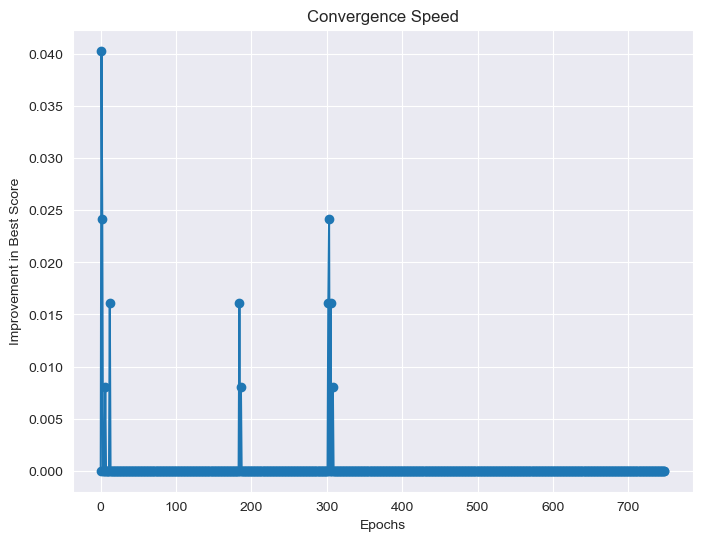

In [122]:
conv = genetic.plot_convergence_speed()
# conv.savefig("Convergencia baseline.png")

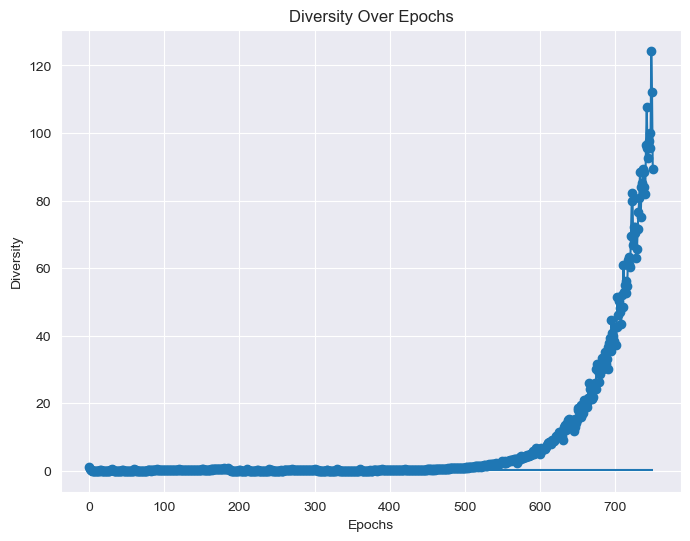

In [123]:
diver = genetic.plot_diversity()
# diver.savefig("Divergencia baseline.png")

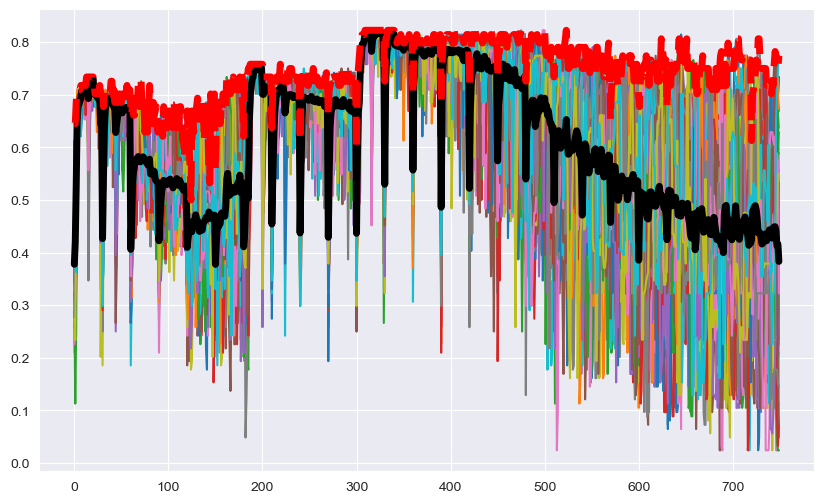

In [124]:
genetic.plot_pop(gen_pop = True)

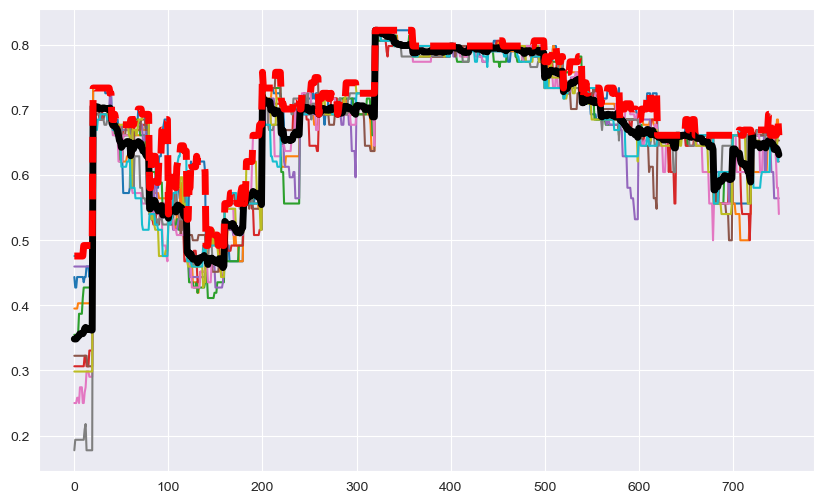

In [125]:
genetic.plot_pop(gen_pop = False)

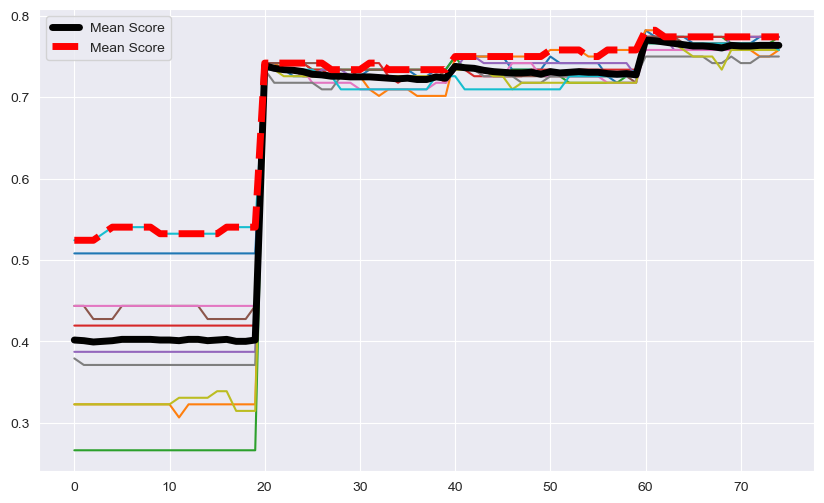

In [86]:
fig, ax = plt.subplots(1, 1, figsize = (10,6))
for agent in genetic.results_elite['agent'].unique():
  data = genetic.results_elite.loc[genetic.results_elite['agent'] == agent]
  ax.plot(data['epoch'], data['score'])
  
mean_scores = genetic.results_elite.groupby('epoch')['score'].mean().reset_index()
max_scores = genetic.results_elite.groupby('epoch')['score'].max().reset_index()

ax.plot(mean_scores['epoch'], mean_scores['score'], color = 'black', lw = 5, label='Mean Score')
ax.plot(max_scores['epoch'], max_scores['score'], color = 'red', lw = 5, ls = 'dashed', label='Mean Score')

ax.legend()
plt.show()

In [64]:
genetic.results_elite

,epoch,agent,best_score,score,individuo
0,0,0,0.000000,0.491935,"[-1.3568004197042673, -0.13908391685351112, 0...."
1,0,1,0.491935,0.241935,"[-1.2042607275481663, -0.11831975794356539, 0...."
2,0,2,0.491935,0.250000,"[-1.302528402916097, -0.1335205601793707, 0.63..."
3,0,3,0.491935,0.443548,"[-1.2042607275481663, -0.1272896007043334, 0.5..."
4,0,4,0.491935,0.354839,"[-1.2042607275481663, -0.12239384683108981, 0...."
...,...,...,...,...,...
1495,74,15,0.758065,0.717742,"[-1.2524311566500927, -0.13708110845082058, 0...."
1496,74,16,0.758065,0.741935,"[-1.1579430072578523, -0.12128059156634517, 0...."
1497,74,17,0.758065,0.709677,"[-1.461169682758442, -0.12653640780075745, 0.5..."
1498,74,18,0.758065,0.717742,"[-1.1913978658820867, -0.11661595342917806, 0...."


In [44]:
genetic.results.loc[genetic.results['agent'] == 124].groupby(by=['epoch', 'agent', 'best_score']).max()

,,,mutation,score
epoch,agent,best_score,,
0.0,124.0,0.588710,0.040000,0.258065
1.0,124.0,0.588710,0.040000,0.419355
2.0,124.0,0.612903,0.040000,0.508065
3.0,124.0,0.612903,0.040000,0.540323
4.0,124.0,0.612903,0.040000,0.572581
...,...,...,...,...
195.0,124.0,0.741935,0.094318,0.653226
196.0,124.0,0.741935,0.094318,0.661290
197.0,124.0,0.741935,0.094318,0.661290


In [45]:
genetic.results_elite.loc[genetic.results_elite['agent'] == 24].groupby(by=['epoch', 'agent', 'best_score']).max()

,,,score,individuo
epoch,agent,best_score,,
0,24,0.572581,0.419355,"[1.4792482266924154, 1.9221224018705325, -0.93..."
1,24,0.588710,0.419355,"[1.4792482266924154, 1.9221224018705325, -0.93..."
2,24,0.588710,0.419355,"[1.4792482266924154, 1.9221224018705325, -0.93..."
3,24,0.612903,0.419355,"[1.4792482266924154, 1.9221224018705325, -0.93..."
4,24,0.612903,0.419355,"[1.4792482266924154, 1.9221224018705325, -0.93..."
...,...,...,...,...
195,24,0.741935,0.653226,"[1.4792482266924154, 1.9221224018705325, -0.93..."
196,24,0.741935,0.645161,"[1.4792482266924154, 1.9221224018705325, -0.93..."
197,24,0.741935,0.645161,"[1.4792482266924154, 1.9221224018705325, -0.93..."


In [474]:
genetic.results.loc[genetic.results['agent'] == 1] # mostra evolução do agente 1a

,epoch,agent,best_score,score
1,0.0,1.0,0.467742,0.395161
76,1.0,1.0,0.701613,0.419355
151,2.0,1.0,0.741935,0.548387
226,3.0,1.0,0.806452,0.661290
301,4.0,1.0,0.830645,0.725806
...,...,...,...,...
37126,495.0,1.0,0.919355,0.637097
37201,496.0,1.0,0.919355,0.693548
37276,497.0,1.0,0.919355,0.766129
37351,498.0,1.0,0.919355,0.741935


In [303]:
genetic.best

array([ 0.77915115,  0.77173948, -0.71789164, -0.5219297 ,  1.82515135,
        0.08130865, -0.48714016,  0.59741453, -0.15733416, -0.11383148,
        0.17722137,  0.18013043, -1.63064938,  1.09477191, -1.32479408,
       -0.22851951])

In [304]:
genetic.population

array([[ 0.77915991,  0.77173946, -0.71789061, ...,  1.05393914,
        -1.32479408, -0.21774981],
       [ 0.77915559,  0.77060882, -0.72772493, ...,  1.08765654,
        -1.3301525 , -0.22193864],
       [ 0.77915677,  0.77173948, -0.71789079, ...,  1.09113634,
        -1.32224304, -0.22856997],
       ...,
       [ 0.77915991,  0.77173947, -0.71789988, ...,  1.0852596 ,
        -1.32479407, -0.23100572],
       [ 0.77915991,  0.77186019, -0.73606495, ...,  1.08765654,
        -1.32478213, -0.22857375],
       [ 0.77915991,  0.77051723, -0.69046915, ...,  1.08743881,
        -1.32421901, -0.22857005]])

In [305]:
genetic.initial_pop

array([[ 1.15762112, -0.92011797, -0.44439472, ...,  1.40164859,
         0.08651224, -0.73956978],
       [ 0.52814726,  1.74173557,  0.94053706, ..., -0.56522315,
        -0.50606494,  0.44308307],
       [ 0.36696972,  0.72162774, -0.53357019, ...,  0.29938483,
         0.59958753,  0.97013764],
       ...,
       [ 0.34917163,  0.59231625,  0.63918298, ..., -2.01444442,
        -1.22522988, -0.37798433],
       [ 0.45518135, -0.42516477, -0.58996607, ..., -0.16987373,
         0.63336035, -0.28679731],
       [-1.97203265, -1.31690699,  0.62096333, ...,  0.75258522,
         0.29615865, -1.53054834]])

In [191]:
for row in genetic.population:
  print(sum(abs(genetic.best - row)/abs(genetic.best))/len(genetic.best))

0.004136378939033041
0.058695271856558304
0.02405059572445709
0.03315863555180889
0.012661999589695522


In [223]:
genetic.results.loc[genetic.results['agent'] == 1] 

,epoch,agent,best_score,score,individuo
1,0,1,0.153226,0.056452,"[-1.5802451093694183, -0.18634601265220543, -0..."
8,1,1,0.322581,0.072581,"[-1.1048503904082507, 0.4827516739742215, -0.9..."
15,2,1,0.362903,0.225806,"[-0.8093708889985993, 0.164817356551815, -0.75..."
22,3,1,0.362903,0.290323,"[-0.6616311382937736, 0.005850197840611776, -0..."
29,4,1,0.362903,0.322581,"[-0.5877612629413609, -0.07363338151498984, -0..."
...,...,...,...,...,...
666,95,1,0.403226,0.403226,"[-0.4979430036410999, -0.10790766763707144, -0..."
673,96,1,0.403226,0.403226,"[-0.49794292789748, -0.2345376727826262, -0.59..."
680,97,1,0.411290,0.403226,"[-0.4052005029064668, -0.17122225695660964, -0..."
687,98,1,0.411290,0.395161,"[-0.35882929041096023, -0.13956454904360138, -..."


In [137]:
for row in genetic.results.loc[genetic.results['agent'] == 1]['individuo']:
  print(sum(genetic.best - row))

0.040556228835677555
0.040556228835677555
0.040556228835677555
0.040556228835677555
0.040556228835677555
0.040556228835677555
0.040556228835677555
0.040556228835677555
0.040556228835677555
0.040556228835677555
0.040556228835677555
0.040556228835677555
0.040556228835677555
0.040556228835677555
0.040556228835677555
0.040556228835677555
0.040556228835677555
0.040556228835677555
0.040556228835677555
0.040556228835677555
0.040556228835677555
0.040556228835677555
0.040556228835677555
0.040556228835677555
0.040556228835677555
0.040556228835677555
0.040556228835677555
0.040556228835677555
0.040556228835677555
0.040556228835677555


In [33]:
df_file = pd.read_csv('resultados_AG.csv')
df_file.loc[df_file['score_pos'] == df_file['score_pos'].max()]

,n_models,n_epochs,n_population,score_pre,score_pos,time
3,20.0,75.0,150.0,0.629630,0.981481,140.050545
27,30.0,100.0,125.0,0.444444,0.981481,273.879413
31,30.0,125.0,100.0,0.444444,0.981481,237.955362
52,35.0,125.0,125.0,0.314815,0.981481,361.879672
56,35.0,150.0,100.0,0.314815,0.981481,347.313499
65,40.0,100.0,75.0,0.370370,0.981481,196.178422
102,70.0,75.0,125.0,0.351852,0.981481,551.001703


In [290]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=100,
                             random_state=seed,
                             max_depth=8,
                             bootstrap=True)
rfc.fit(x_train, y_train)

y_pred = rfc.predict(x_test)

score(y_pred, y_test)

Score :: 0.9814814814814815


In [291]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=seed)
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

score(y_pred, y_test)

Score :: 0.9444444444444444
